# Загружаем данные

In [116]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.impute import SimpleImputer

import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

import re

from sklearn.preprocessing import TargetEncoder

In [117]:
df=pd.read_csv('/mnt/All/Downloads/car_price_prediction_1.csv')
df=df.drop('ID',axis=1)

In [118]:
df

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
19233,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,8
19234,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
19235,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258 km,4.0,Automatic,Front,04-May,Left wheel,Black,4


# Преобразуем данные

In [119]:
df.loc[df['Mileage'].notna(),'Mileage']=df.loc[df['Mileage'].notna(),'Mileage'].map(lambda x: re.match('[\d\.]+', x))
df.loc[df['Mileage'].notna(),'Mileage']=df.loc[df['Mileage'].notna(),'Mileage'].map(lambda x: x.group())
df['Mileage']= df['Mileage'].astype('int')

df['Levy']=df['Levy'].replace('-',0)
df['Levy']=df['Levy'].astype('int')

df['Leather interior']=df['Leather interior'].replace(('Yes','No'),('1','0'))
df['Leather interior']=df['Leather interior'].astype('int')

df['Turbo']=df['Engine volume'].str.find('Turbo').replace(-1,0)
df['Turbo']=df['Turbo'].replace(range(1,10),1)

df.loc[df['Engine volume'].notna(),'Engine volume']=df.loc[df['Engine volume'].notna(),'Engine volume'].map(lambda x: re.match('[\d\.]+', x))
df.loc[df['Engine volume'].notna(),'Engine volume']=df.loc[df['Engine volume'].notna(),'Engine volume'].map(lambda x: x.group())
df['Engine volume']= df['Engine volume'].astype('float')

In [120]:
idx=(df.applymap(type) == str).any(axis=0)
txt=df.columns[idx]

df[txt]= df[txt].astype('category')

# Анализируем данные

In [121]:
display(df.head())
df.shape

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo
0,13328,1399,LEXUS,RX 450,2010,Jeep,1,Hybrid,3.5,186005,6.0,Automatic,4x4,04-May,Left wheel,Silver,12,0
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,0,Petrol,3.0,192000,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8,0
2,8467,0,HONDA,FIT,2006,Hatchback,0,Petrol,1.3,200000,4.0,Variator,Front,04-May,Right-hand drive,Black,2,0
3,3607,862,FORD,Escape,2011,Jeep,1,Hybrid,2.5,168966,4.0,Automatic,4x4,04-May,Left wheel,White,0,0
4,11726,446,HONDA,FIT,2014,Hatchback,1,Petrol,1.3,91901,4.0,Automatic,Front,04-May,Left wheel,Silver,4,0


(19237, 18)

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Price             19237 non-null  int64   
 1   Levy              19237 non-null  int64   
 2   Manufacturer      19237 non-null  category
 3   Model             19237 non-null  category
 4   Prod. year        19237 non-null  int64   
 5   Category          19237 non-null  category
 6   Leather interior  19237 non-null  int64   
 7   Fuel type         19237 non-null  category
 8   Engine volume     19237 non-null  float64 
 9   Mileage           19237 non-null  int64   
 10  Cylinders         19237 non-null  float64 
 11  Gear box type     19237 non-null  category
 12  Drive wheels      19237 non-null  category
 13  Doors             19237 non-null  category
 14  Wheel             19237 non-null  category
 15  Color             19237 non-null  category
 16  Airbags           1923

In [123]:
for x in df[txt]:
    print(x, ": ",len(df[x].unique()))

Manufacturer :  65
Model :  1590
Category :  11
Fuel type :  7
Gear box type :  4
Drive wheels :  3
Doors :  3
Wheel :  2
Color :  16


<Axes: >

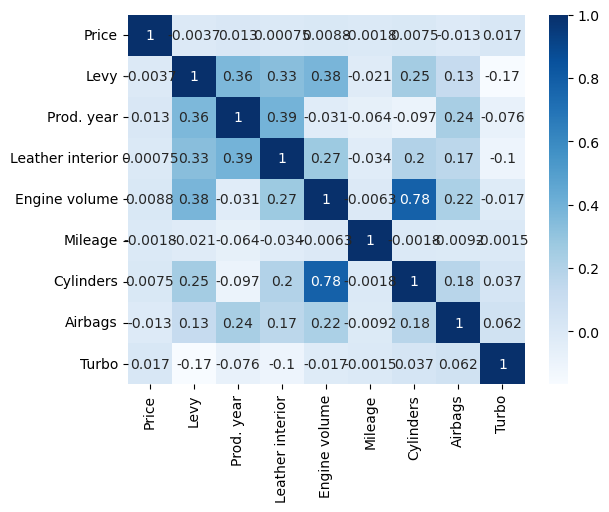

In [124]:
df_inta=df.select_dtypes(include=['float64','int64'])
sns.heatmap(df_inta.corr(), cmap='Blues',annot=True)

# Чистим данные

In [125]:
# print(df['Model'].value_counts())
m=df['Model'].value_counts()
print(len(m))
m=m[m<5].index
print(len(m))

# df=df.drop('Model',axis=1)
enc_auto = TargetEncoder(smooth="auto",target_type="continuous")
df['Model'] = enc_auto.fit_transform(df['Model'].values.reshape(-1, 1), df['Price'])

1590
1267


In [126]:
print(len(df['Manufacturer'].value_counts()))

m=df['Manufacturer'].value_counts()
m=m[m<5].index
print(len(m))

# df=df.drop('Manufacturer',axis=1)
enc_auto = TargetEncoder(smooth="auto",target_type="continuous")
df['Manufacturer'] = enc_auto.fit_transform(df['Manufacturer'].values.reshape(-1, 1), df['Price'])

65
21


In [127]:
df['Color'].value_counts()

df=df.drop('Color',axis=1)

In [128]:
m=df['Fuel type'].value_counts()
print(len(m))
m=m[m<200].index
print(len(m))

df=df.replace(m,'Another')
# df=df.dropna()

7
2


In [129]:
idx=(df.applymap(type) == str).any(axis=0)
txt=df.columns[idx]
for x in df[txt]:
    print(x, ": ",len(df[x].unique()))

Category :  11
Fuel type :  6
Gear box type :  4
Drive wheels :  3
Doors :  3
Wheel :  2


## Удаляем выбросы

/tmp/ipykernel_60192/2202792114.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

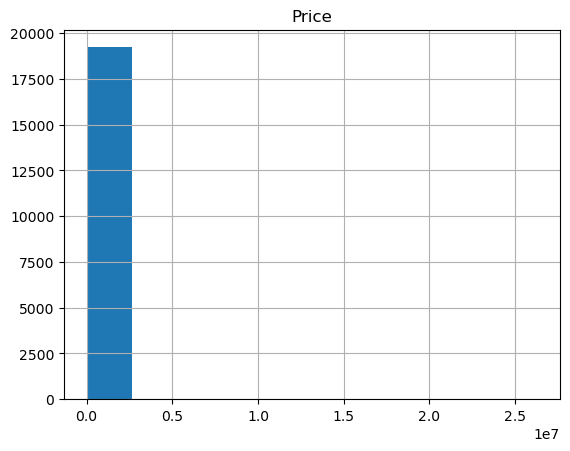

<Figure size 640x480 with 0 Axes>

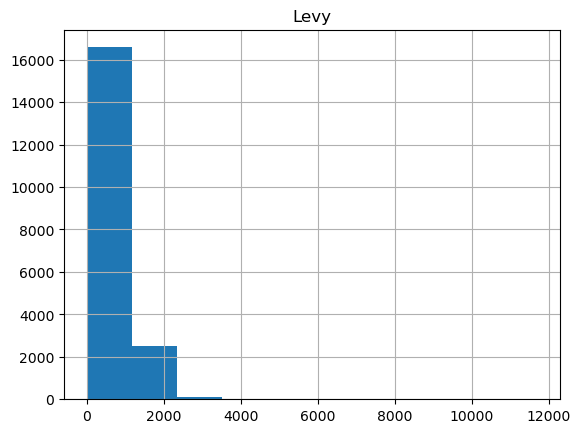

<Figure size 640x480 with 0 Axes>

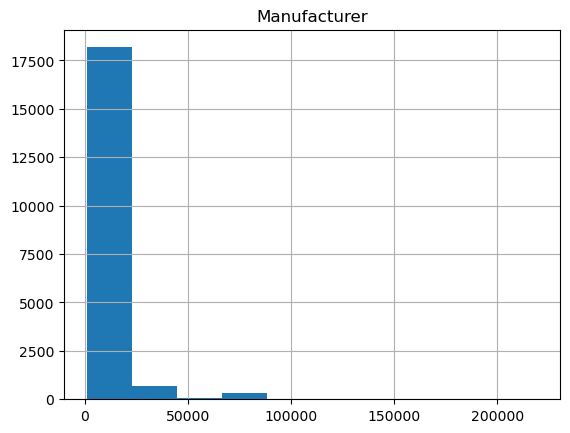

<Figure size 640x480 with 0 Axes>

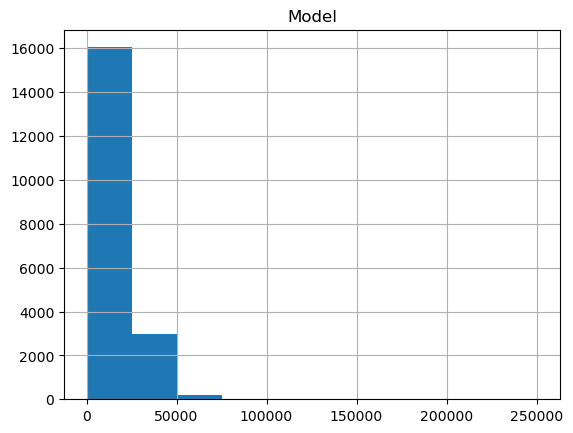

<Figure size 640x480 with 0 Axes>

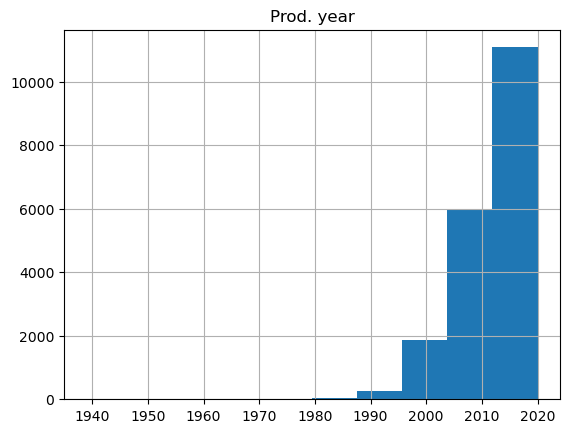

<Figure size 640x480 with 0 Axes>

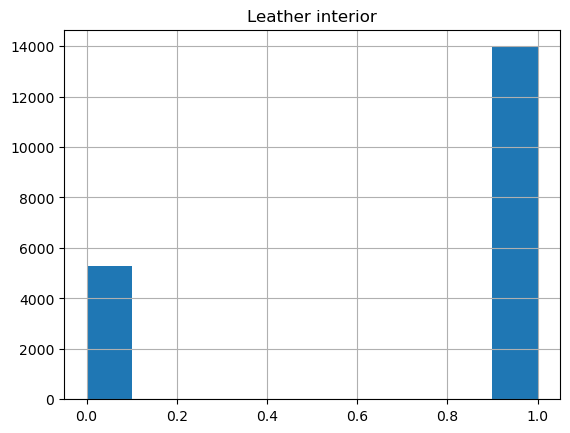

<Figure size 640x480 with 0 Axes>

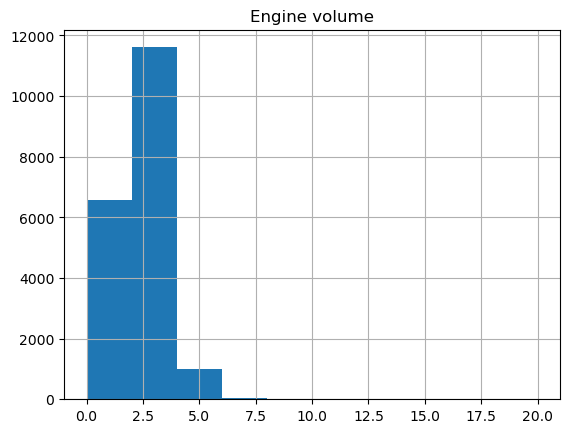

<Figure size 640x480 with 0 Axes>

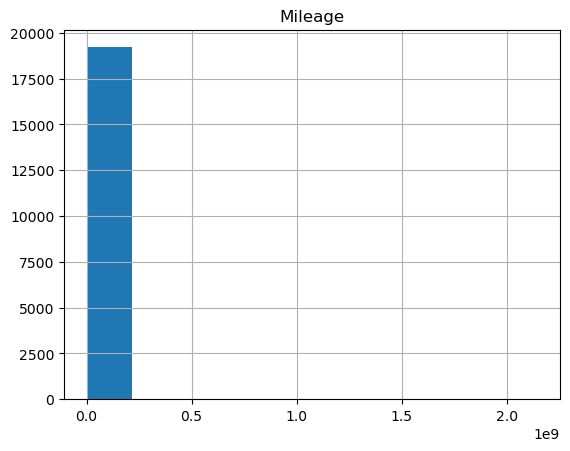

<Figure size 640x480 with 0 Axes>

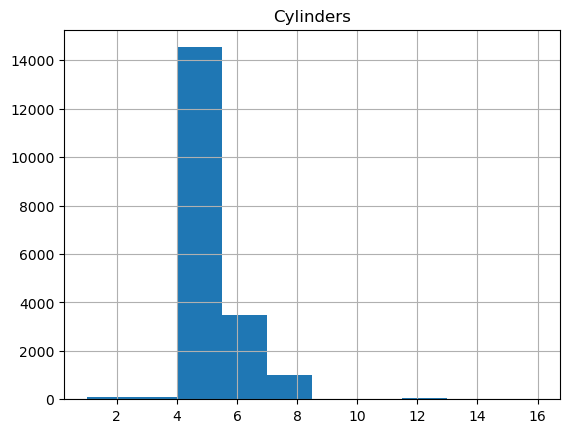

<Figure size 640x480 with 0 Axes>

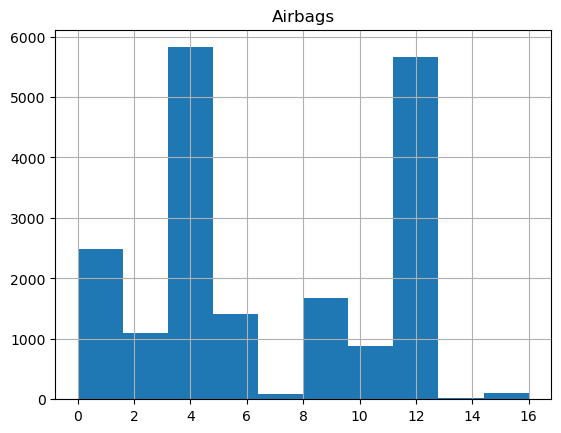

<Figure size 640x480 with 0 Axes>

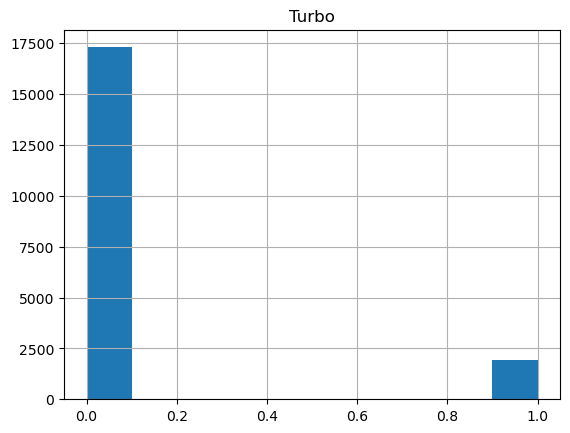

In [130]:
df_inta=df.select_dtypes(include=['float64','int64'])
df['Price']=np.log(df['Price'])
for column in df_inta:
    plt.figure()
    df_inta.hist(column=[column])

In [131]:
z=np.abs(stats.zscore(df_inta))
df[df_inta.columns]=df_inta[(z<3).all(axis=1)]
df=df.dropna()

/tmp/ipykernel_60192/2020584914.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

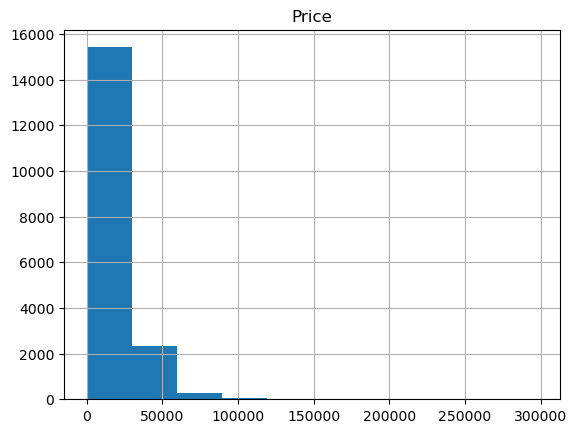

<Figure size 640x480 with 0 Axes>

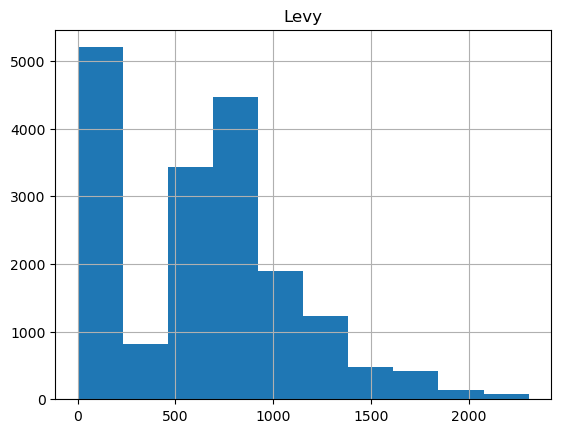

<Figure size 640x480 with 0 Axes>

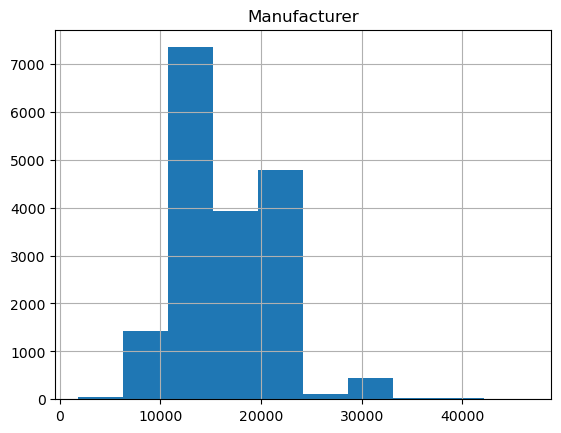

<Figure size 640x480 with 0 Axes>

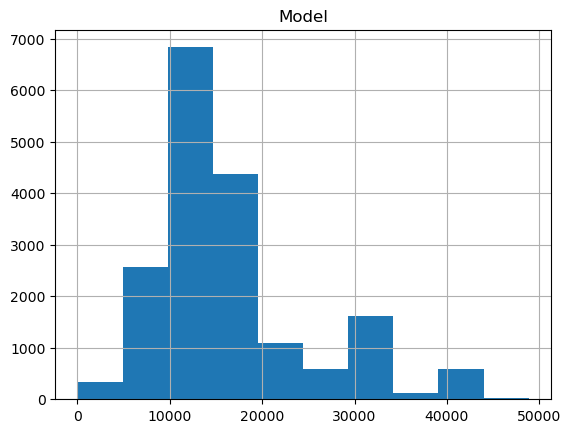

<Figure size 640x480 with 0 Axes>

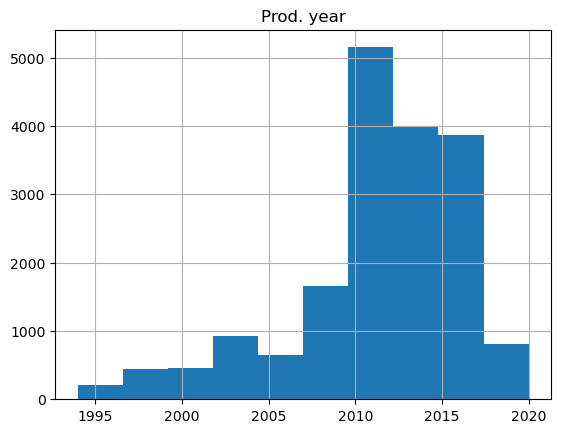

<Figure size 640x480 with 0 Axes>

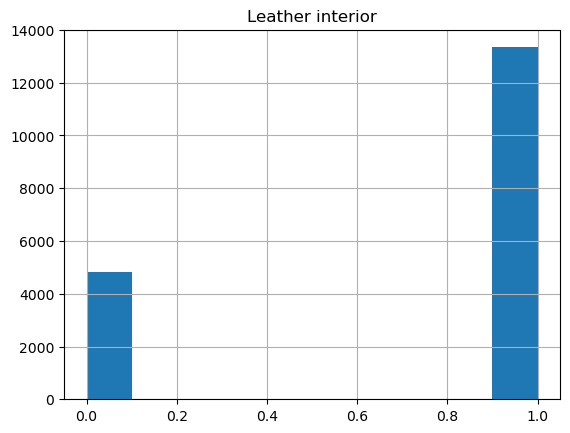

<Figure size 640x480 with 0 Axes>

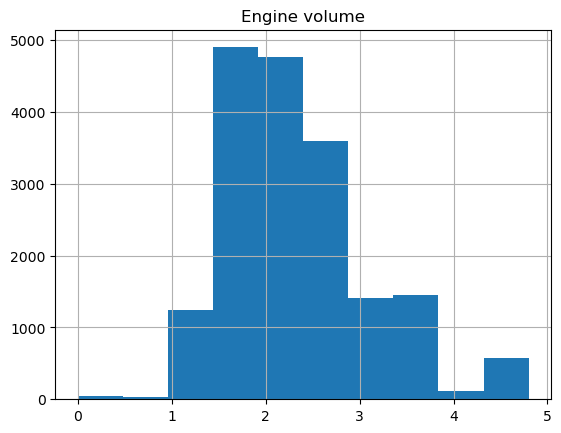

<Figure size 640x480 with 0 Axes>

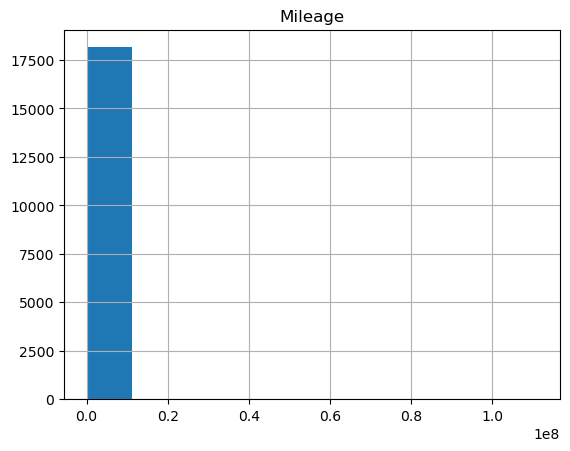

<Figure size 640x480 with 0 Axes>

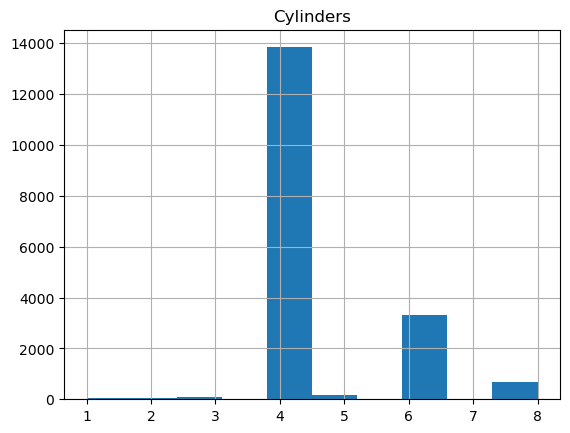

<Figure size 640x480 with 0 Axes>

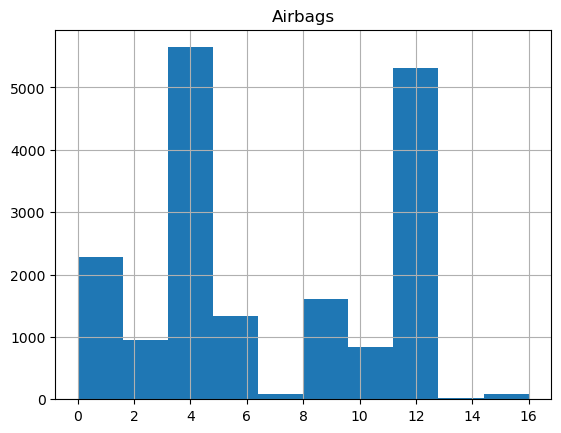

<Figure size 640x480 with 0 Axes>

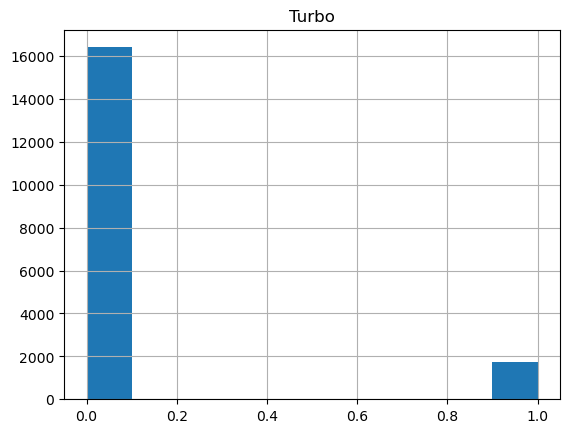

In [132]:
for column in df_inta:
    plt.figure()
    df.hist(column=[column])

# Пребразуем текстовые данные в характеристики и задаем x с y

In [133]:
#выбираю столбцы с текстом
dum=pd.concat([df_inta,pd.get_dummies(df[txt],drop_first=True)],axis=1)
dum=dum.dropna()
dum=dum.reset_index(drop=True)
dum

,Price,Levy,Manufacturer,Model,Prod. year,Leather interior,Engine volume,Mileage,Cylinders,Airbags,...,Fuel type_Petrol,Fuel type_Another,Gear box type_Manual,Gear box type_Tiptronic,Gear box type_Variator,Drive wheels_Front,Drive wheels_Rear,Doors_04-May,Doors_>5,Wheel_Right-hand drive
0,13328,1399,19387.030098,9819.015991,2010,1,3.5,186005,6.0,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,16621,1018,14849.002165,10343.984147,2011,0,3.0,192000,6.0,8,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,8467,0,14992.304544,10795.560048,2006,0,1.3,200000,4.0,2,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
3,3607,862,15792.446673,8190.201958,2011,1,2.5,168966,4.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,11726,446,14992.304544,11301.407283,2014,1,1.3,91901,4.0,4,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18154,8467,0,18525.209170,7592.829897,1999,1,2.0,300000,4.0,5,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18155,15681,831,22340.810291,14150.062240,2011,1,2.4,161600,4.0,8,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
18156,26108,836,22295.390722,29778.153660,2010,1,2.0,116365,4.0,4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
18157,5331,1288,15011.250602,17712.739836,2007,1,2.0,51258,4.0,4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [134]:
y=dum['Price']
dum=dum.drop('Price',axis=1)
x=dum

# Проверяем на мультиколлинеарность

In [135]:
vif=pd.DataFrame()
vif['feature']=x.columns
vif['vif']=[variance_inflation_factor(x.values,i) for i in range(len(x.columns))]
vif

,feature,vif
0,Levy,4.076770
1,Manufacturer,23.031713
2,Model,9.201487
3,Prod. year,744.540354
4,Leather interior,6.056817
5,Engine volume,41.549891
6,Mileage,1.028125
7,Cylinders,66.244574
8,Airbags,4.365341
9,Turbo,1.522285


In [136]:
try:
    while(vif.max()[1]>5 ):
        m=vif.max()[1]
        m=vif[vif['vif']==m]['feature']
        x=x.drop(m,axis=1)
        vif=pd.DataFrame()
        vif['feature']=x.columns
        vif['vif']=[variance_inflation_factor(x.values,i) for i in range(len(x.columns))]
except:
    print(vif)

In [137]:
vif.max()

feature    Wheel_Right-hand drive
vif                      4.766411
dtype: object

In [138]:
x

,Levy,Leather interior,Mileage,Airbags,Turbo,Category_Coupe,Category_Goods wagon,Category_Hatchback,Category_Jeep,Category_Limousine,...,Fuel type_Hybrid,Fuel type_LPG,Fuel type_Another,Gear box type_Manual,Gear box type_Tiptronic,Gear box type_Variator,Drive wheels_Front,Drive wheels_Rear,Doors_>5,Wheel_Right-hand drive
0,1399,1,186005,12,0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1018,0,192000,8,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,0,200000,2,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,862,1,168966,0,0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,446,1,91901,4,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18154,0,1,300000,5,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
18155,831,1,161600,8,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
18156,836,1,116365,4,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18157,1288,1,51258,4,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [139]:
# X1=x.copy()
# X1['intercept']=np.ones([X1.shape[0],1])
# results = sm.OLS(y, X1).fit()
# results.summary()

In [140]:
# display([results.pvalues[i] for i in x])
# for i in x:
#     if results.pvalues[i]>0.05:
#         x=x.drop(i,axis=1)

In [141]:
# pval=[results.pvalues[i] for i in x]
# display(max(pval))
# display(len(pval)) #исключили около 100 элементов

# display(pval)

# Строим модели

In [142]:
sys=LinearRegression()
sys.fit(x,y)

LinearRegression()

In [143]:
dt = DecisionTreeRegressor(random_state=1)
dt.fit(x, y)

DecisionTreeRegressor(random_state=1)

# Оцениваем их качество

### Коэффициэнт детерминации

In [144]:
dt.score(x,y)

0.9812203319708382

In [145]:
sys.score(x,y) 

0.2019541580058567

### Анализ остатков

In [146]:
pred=pd.Series(sys.predict(x))
dtpred=pd.Series(dt.predict(x))

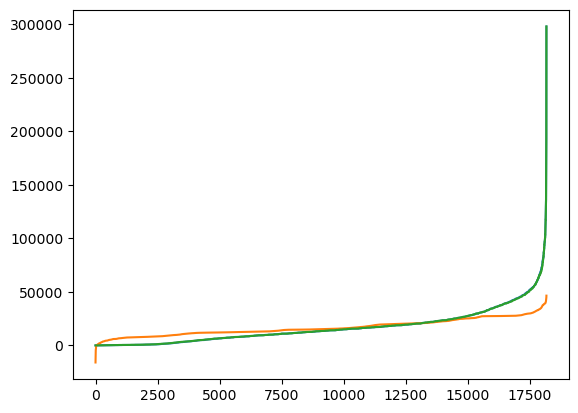

In [147]:
plt.figure()
plt.plot(range(len(y)),y.sort_values())
plt.plot(range(len(y)),pred.sort_values())
plt.plot(range(len(y)),dtpred.sort_values())

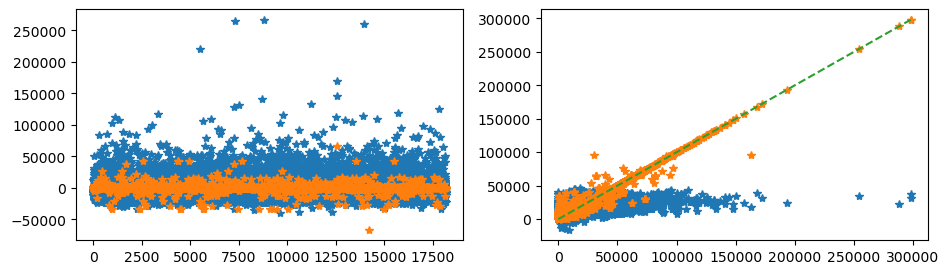

In [148]:
ideal=[y.min(),y.max()]
fig, ax = plt.subplots(1,2,figsize=(11,3))
ax[0].plot(y-pred,'*')
ax[0].plot(y-dtpred,'*')
ax[0].set_yscale('linear')

ax[1].plot(y,pred,'*')
ax[1].plot(y,dtpred,'*')
ax[1].plot(ideal,ideal,'--')
ax[1].set_yscale('linear')